In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import cv2
from uco.data_loader import (
    RLEInput, 
    pivot_df,
    CutoutBase,
    DistortionBase,
    RandomResizeCropBase,
    CutoutDistortionTransforms,
)

In [2]:
train_csv = '../data/raw/train.csv'
df = pd.read_csv(train_csv)
df = pivot_df(df)
df.head()

,rle0,rle1,rle2,rle3,n_classes,c0,c1,c2,c3
Image,,,,,,,,,
0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,2,True,True,False,False
002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,3,True,True,False,True
0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,3,True,True,False,True
0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,2,False,True,True,False
003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,3,True,False,True,True


In [3]:
img_dir = Path('../data/raw/train_images')
img_filenames = list(img_dir.glob('*.jpg'))
len(img_filenames)

5546

In [4]:
imgs = [cv2.imread(str(f)) for f in img_filenames[10:13]]
rles = [df.loc[f.name, ['rle0', 'rle1', 'rle2', 'rle3']] for f in img_filenames[10:13]]
masks = [np.stack([RLEInput.from_str(s).to_mask() for s in row], axis=2) for row in rles]

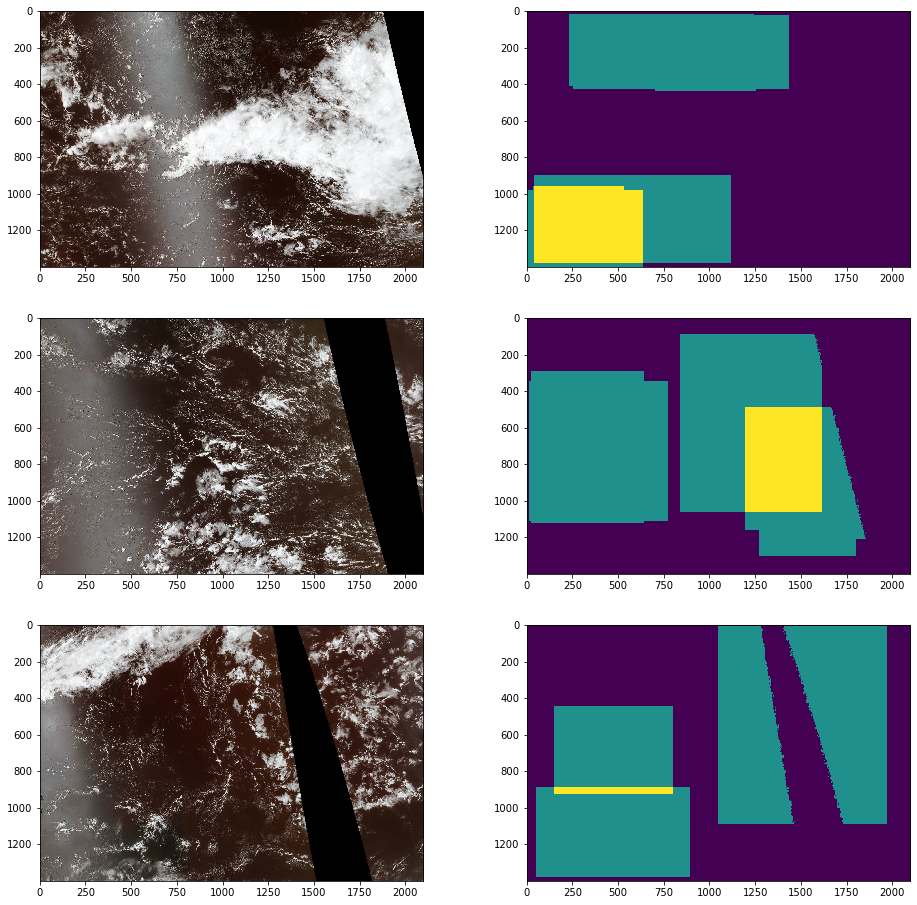

In [5]:
def plot_imgs(imgs, masks):
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    for i in range(3):
        axs[i][0].imshow(imgs[i])
        axs[i][1].imshow(masks[i].sum(axis=2))
    plt.show()
plot_imgs(imgs, masks)

(1400, 2100, 3)
(1400, 2100, 3)
(1400, 2100, 3)


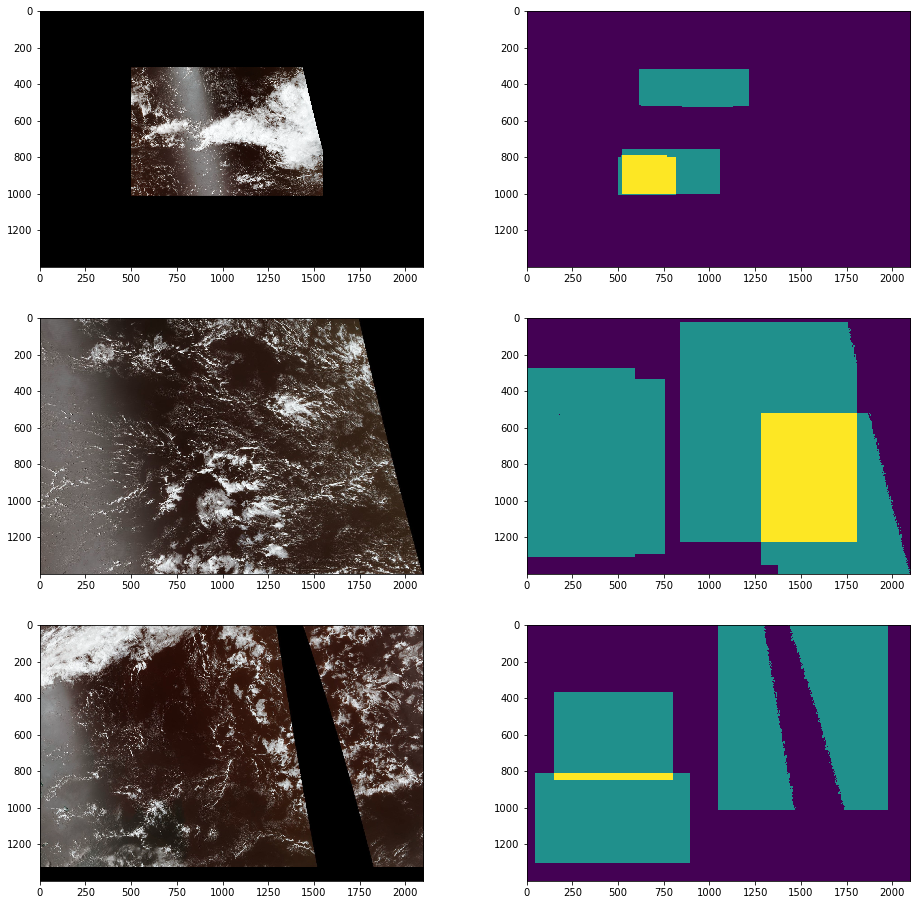

In [6]:
tsfm = A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, border_mode=0)

tsfm_out = [tsfm(image=imgs[i], mask=masks[i]) for i in range(3)]
tsfm_imgs = [tsfm['image'] for tsfm in tsfm_out]
tsfm_mask = [tsfm['mask'] for tsfm in tsfm_out]
for img in tsfm_imgs:
    print(img.shape)
plot_imgs(tsfm_imgs, tsfm_mask)

In [7]:
import scipy.signal

In [11]:
k = np.array([
    [1, 0, 0],
    [1, 1, 1],
    [0, 0, 0]
])
a = np.array([
    np.ones(5),
    np.zeros(5),
    np.ones(5),
    np.zeros(5),
    np.ones(5)
])
a

array([[1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.]])

In [12]:
scipy.signal.convolve2d(k, a, mode='valid')

array([[1., 1., 1.],
       [3., 3., 3.],
       [1., 1., 1.]])